# 非スパース行列変換による機械学習モデルの効果検証

In [1]:
from pathlib import Path
import sys
import scipy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

In [49]:
np.set_printoptions(precision=2, suppress=True)

In [2]:
result_dir_path = Path('result')

if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

In [24]:
X_data, y_data = make_classification(
    n_classes=4,
    n_samples=10,
    n_features=6,
    n_clusters_per_class=1,
    n_informative=4,
    random_state=42
)

In [50]:
X_data

array([[-0.78, -0.84,  0.25,  1.03,  0.19,  1.19],
       [ 0.30,  2.48, -0.37, -2.73,  0.52, -1.71],
       [-2.06, -0.60, -0.25, -0.51,  2.05, -1.83],
       [-1.47, -0.89, -0.00,  2.01,  0.00,  2.01],
       [-0.94, -1.12,  0.72, -1.33,  2.07, -1.39],
       [-0.52, -0.95, -1.26,  1.74, -0.31, -1.91],
       [-1.90, -0.02, -2.04,  2.66, -0.45, -1.11],
       [-0.47, -2.68,  2.40, -2.17,  3.01, -0.43],
       [-0.18,  2.40, -0.05, -1.84,  0.23,  0.40],
       [-1.38, -0.90,  0.40, -1.10,  2.12, -1.53]])

In [26]:
y_data

array([2, 3, 0, 2, 0, 1, 1, 1, 3, 0])

## データのスパース化

In [30]:
data = pd.DataFrame(
    X_data, 
    columns=['X' + str(i + 1) for i in range(X_data.shape[1])]
)

In [31]:
new_0_col = 10

data = pd.concat([
    data,
    pd.DataFrame(
        np.zeros((data.shape[0], new_0_col)), 
        columns=['X' + str(i + data.shape[1] + 1) for i in range(new_0_col)]
    )
], axis=1)
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
0,-0.779528,-0.837849,0.254595,1.029391,0.190196,1.189947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.295846,2.482931,-0.369688,-2.733714,0.521889,-1.706691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.060529,-0.602945,-0.249969,-0.509678,2.053720,-1.831052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.468152,-0.888309,-0.003092,2.008722,0.000838,2.006542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.940636,-1.118858,0.721600,-1.329698,2.071165,-1.389449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.522425,-0.947309,-1.263343,1.740550,-0.309629,-1.905826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-1.904912,-0.021099,-2.043454,2.664477,-0.446772,-1.106040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.473545,-2.684000,2.396442,-2.169339,3.007581,-0.428708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.181898,2.400234,-0.050047,-1.843234,0.225769,0.399887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-1.378618,-0.896790,0.396128,-1.103921,2.117051,-1.532288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
data_sparsed = scipy.sparse.csr_matrix(data)

In [51]:
data_sparsed.data

array([-0.78, -0.84,  0.25,  1.03,  0.19,  1.19,  0.30,  2.48, -0.37,
       -2.73,  0.52, -1.71, -2.06, -0.60, -0.25, -0.51,  2.05, -1.83,
       -1.47, -0.89, -0.00,  2.01,  0.00,  2.01, -0.94, -1.12,  0.72,
       -1.33,  2.07, -1.39, -0.52, -0.95, -1.26,  1.74, -0.31, -1.91,
       -1.90, -0.02, -2.04,  2.66, -0.45, -1.11, -0.47, -2.68,  2.40,
       -2.17,  3.01, -0.43, -0.18,  2.40, -0.05, -1.84,  0.23,  0.40,
       -1.38, -0.90,  0.40, -1.10,  2.12, -1.53])

In [39]:
data_sparsed.indices

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5], dtype=int32)

In [40]:
data_sparsed.indptr

array([ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54, 60], dtype=int32)

In [52]:
data_sparsed.data[data_sparsed.indices[
    data_sparsed.indptr[0]: data_sparsed.indptr[1] 
]]

array([-0.78, -0.84,  0.25,  1.03,  0.19,  1.19])

## スパースなデータで学習

In [3]:
n_splits = 5

In [4]:
cv_results = []
for n_samples in [10000, 20000]:

    X_data, y_data = make_classification(
        n_classes=10,
        n_samples=n_samples,
        n_features=100,
        n_clusters_per_class=1,
        n_informative=4,
        random_state=42
    )

    X_data = pd.DataFrame(X_data, columns=['x' + str(i + 1) for i in range(X_data.shape[1])])

    for n_new_0_col in [0, 10, 100, 1000, 10000]:

        X_data_ = pd.concat([
            X_data, 
            pd.DataFrame(
                np.zeros((X_data.shape[0], n_new_0_col)), 
                columns=['x' + str(X_data.shape[1] + i + 1) for i in range(n_new_0_col)]
            )
        ], axis=1)

        X_train, X_test, y_train, y_test = train_test_split(
            X_data_, y_data, test_size=0.3, random_state=42, shuffle=True
        )

        kf = StratifiedKFold(n_splits=n_splits)

        loop = 1
        for indexes_train, indexes_valid in kf.split(X_train, y_train):

            X_train_cv = X_train.iloc[indexes_train]
            y_train_cv = y_train[indexes_train]
            X_valid_cv = X_train.iloc[indexes_valid]
            y_valid_cv = y_train[indexes_valid]

            start_time = time.time()
            model = xgb.XGBClassifier(random_state=42, use_label_encoder=False)
            model.fit(
                X_train_cv, 
                y_train_cv,
                early_stopping_rounds=30,
                eval_set=[(X_valid_cv, y_valid_cv)],
                eval_metric='mlogloss',
                verbose=0
            )
            end_time = time.time()

            score = model.score(X_test, y_test)
            print('Samples: {}, New 0 Col: {}, [{}/{}], Score: {:.0f}%, {:.0f}s'.format(
                n_samples, n_new_0_col, loop, n_splits, score * 100,
                end_time - start_time
            ))

            cv_results.append([n_samples, n_new_0_col, loop, end_time - start_time, score])
            loop += 1

cv_results = pd.DataFrame(
    cv_results, 
    columns=['n_samples', 'new_n_0_col', 'loop', 'elapsed_time', 'score']
)
cv_results.to_csv(result_dir_path.joinpath('model_result_sparse.csv'), index=False)
cv_results

Samples: 10000, New 0 Col: 0, [1/5], Score: 71%, 10s
Samples: 10000, New 0 Col: 0, [2/5], Score: 71%, 11s
Samples: 10000, New 0 Col: 0, [3/5], Score: 71%, 10s
Samples: 10000, New 0 Col: 0, [4/5], Score: 71%, 10s
Samples: 10000, New 0 Col: 0, [5/5], Score: 70%, 13s
Samples: 10000, New 0 Col: 10, [1/5], Score: 71%, 13s
Samples: 10000, New 0 Col: 10, [2/5], Score: 71%, 13s
Samples: 10000, New 0 Col: 10, [3/5], Score: 71%, 11s
Samples: 10000, New 0 Col: 10, [4/5], Score: 71%, 12s
Samples: 10000, New 0 Col: 10, [5/5], Score: 70%, 13s
Samples: 10000, New 0 Col: 100, [1/5], Score: 71%, 16s
Samples: 10000, New 0 Col: 100, [2/5], Score: 71%, 15s
Samples: 10000, New 0 Col: 100, [3/5], Score: 71%, 13s
Samples: 10000, New 0 Col: 100, [4/5], Score: 71%, 13s
Samples: 10000, New 0 Col: 100, [5/5], Score: 70%, 15s
Samples: 10000, New 0 Col: 1000, [1/5], Score: 71%, 43s
Samples: 10000, New 0 Col: 1000, [2/5], Score: 71%, 45s
Samples: 10000, New 0 Col: 1000, [3/5], Score: 71%, 37s
Samples: 10000, New 0 

,n_samples,new_n_0_col,loop,elapsed_time,score
0,10000,0,1,10.431001,0.707000
1,10000,0,2,10.975796,0.712000
2,10000,0,3,9.872943,0.706000
3,10000,0,4,10.331322,0.708333
4,10000,0,5,12.757954,0.704667
5,10000,10,1,13.444246,0.707000
6,10000,10,2,13.044032,0.712000
7,10000,10,3,10.822869,0.706000
8,10000,10,4,11.866188,0.708333
9,10000,10,5,13.170595,0.704667


## 非スパースなデータで学習

In [3]:
n_splits = 5

In [5]:
cv_results = []
for n_samples in [10000, 20000]:

    X_data, y_data = make_classification(
        n_classes=10,
        n_samples=n_samples,
        n_features=100,
        n_clusters_per_class=1,
        n_informative=4,
        random_state=42
    )

    X_data = pd.DataFrame(X_data, columns=['x' + str(i + 1) for i in range(X_data.shape[1])])
    
    for n_new_0_col in [0, 10, 100, 1000, 10000]:

        X_data_ = pd.concat([
            X_data, 
            pd.DataFrame(
                np.zeros((X_data.shape[0], n_new_0_col)), 
                columns=['x' + str(X_data.shape[1] + i + 1) for i in range(n_new_0_col)]
            )
        ], axis=1)

        X_train, X_test, y_train, y_test = train_test_split(
            X_data_, y_data, test_size=0.3, random_state=42, shuffle=True
        )

        kf = StratifiedKFold(n_splits=n_splits)

        loop = 1
        for indexes_train, indexes_valid in kf.split(X_train, y_train):

            X_train_cv = X_train.iloc[indexes_train]
            y_train_cv = y_train[indexes_train]
            X_valid_cv = X_train.iloc[indexes_valid]
            y_valid_cv = y_train[indexes_valid]

            start_time = time.time()
            model = xgb.XGBClassifier(random_state=42, use_label_encoder=False)
            model.fit(
                scipy.sparse.csr_matrix(X_train_cv),
                y_train_cv,
                early_stopping_rounds=30,
                eval_set=[(scipy.sparse.csr_matrix(X_valid_cv), y_valid_cv)],
                eval_metric='mlogloss',
                verbose=0
            )
            end_time = time.time()

            score = model.score(scipy.sparse.csr_matrix(X_test), y_test)
            print('Samples: {}, New 0 Col: {}, [{}/{}], Score: {:.0f}%, {:.0f}s'.format(
                n_samples, n_new_0_col, loop, n_splits, score * 100,
                end_time - start_time
            ))

            cv_results.append([n_samples, n_new_0_col, loop, end_time - start_time, score])
            loop += 1

cv_results = pd.DataFrame(
    cv_results, 
    columns=['n_samples', 'new_n_0_col', 'loop', 'elapsed_time', 'score']
)
cv_results.to_csv(result_dir_path.joinpath('model_result_non_sparse.csv'), index=False)
cv_results

Samples: 10000, New 0 Col: 0, [1/5], Score: 71%, 10s
Samples: 10000, New 0 Col: 0, [2/5], Score: 71%, 11s
Samples: 10000, New 0 Col: 0, [3/5], Score: 71%, 10s
Samples: 10000, New 0 Col: 0, [4/5], Score: 71%, 11s
Samples: 10000, New 0 Col: 0, [5/5], Score: 70%, 12s
Samples: 10000, New 0 Col: 10, [1/5], Score: 71%, 13s
Samples: 10000, New 0 Col: 10, [2/5], Score: 71%, 13s
Samples: 10000, New 0 Col: 10, [3/5], Score: 71%, 11s
Samples: 10000, New 0 Col: 10, [4/5], Score: 71%, 11s
Samples: 10000, New 0 Col: 10, [5/5], Score: 70%, 12s
Samples: 10000, New 0 Col: 100, [1/5], Score: 71%, 12s
Samples: 10000, New 0 Col: 100, [2/5], Score: 71%, 13s
Samples: 10000, New 0 Col: 100, [3/5], Score: 71%, 11s
Samples: 10000, New 0 Col: 100, [4/5], Score: 71%, 11s
Samples: 10000, New 0 Col: 100, [5/5], Score: 70%, 12s
Samples: 10000, New 0 Col: 1000, [1/5], Score: 71%, 13s
Samples: 10000, New 0 Col: 1000, [2/5], Score: 71%, 14s
Samples: 10000, New 0 Col: 1000, [3/5], Score: 71%, 12s
Samples: 10000, New 0 

,n_samples,new_n_0_col,loop,elapsed_time,score
0,10000,0,1,10.485158,0.707000
1,10000,0,2,11.244554,0.712000
2,10000,0,3,9.923825,0.706000
3,10000,0,4,10.914024,0.708333
4,10000,0,5,11.748947,0.704667
5,10000,10,1,12.534452,0.707000
6,10000,10,2,12.810695,0.712000
7,10000,10,3,11.147156,0.706000
8,10000,10,4,11.089507,0.708333
9,10000,10,5,11.695695,0.704667


## 学習結果をグラフ化

In [20]:
target_data = pd.concat([
    pd.read_csv(result_dir_path.joinpath('model_result_non_sparse.csv')).assign(
        category='non_sparse'
    ),
    pd.read_csv(result_dir_path.joinpath('model_result_sparse.csv')).assign(
        category='sparse'
    )
], axis=0)

plot_data = target_data.groupby(['category', 'new_n_0_col', 'n_samples']).agg({
    'elapsed_time': ['mean', 'std'], 'score': ['mean', 'std']
})
plot_data.columns = ['elapsed_time_mean', 'elapsed_time_std', 'score_mean', 'score_std']
plot_data.reset_index(inplace=True, drop=False)

### 実行時間の比較

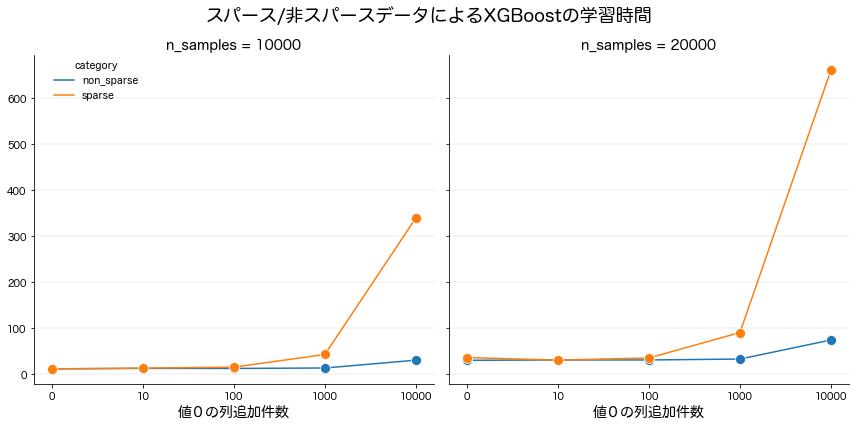

In [58]:
g = sns.relplot(
    data=plot_data.assign(new_n_0_col=lambda x: x.new_n_0_col.astype(str)),
    x='new_n_0_col',
    y='elapsed_time_mean',
    hue='category',
    col='n_samples',
    kind='line',
    marker='o',
    markersize=10
)
g.fig.suptitle('スパース/非スパースデータによるXGBoostの学習時間', fontsize=18, y=0.98, weight='bold')
g.fig.set_figwidth(12)
g.fig.set_figheight(6)
for ax in g.axes.flat:
    ax.set_xlabel('値０の列追加件数', size=14)
    ax.set_title(ax.get_title(), size=14)
g.set_ylabels('')

leg = g._legend
leg.set_bbox_to_anchor([0.17, 0.8])

for i, ax in enumerate(g.axes.flat):
    for tick in ax.get_yticks()[1:-1]:
        ax.axhline(tick, alpha=0.1, color='grey')
        
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('model_result_sparse_vs_non_sparse_slapsed_time.png'), dpi=300)

### 正答率の比較

In [72]:
result = pd.pivot_table(
    data=plot_data[['n_samples', 'category', 'new_n_0_col', 'score_mean', 'score_std']],
    index=['n_samples', 'new_n_0_col'],
    columns='category'
)
result

score_mean            score_std          
category              non_sparse    sparse non_sparse    sparse
n_samples new_n_0_col                                          
10000     0             0.707600  0.707600   0.002803  0.002803
          10            0.707600  0.707600   0.002803  0.002803
          100           0.707600  0.707600   0.002803  0.002803
          1000          0.707600  0.707600   0.002803  0.002803
          10000         0.707600  0.707600   0.002803  0.002803
20000     0             0.761167  0.761167   0.001744  0.001744
          10            0.761167  0.761167   0.001744  0.001744
          100           0.761167  0.761167   0.001744  0.001744
          1000          0.761167  0.761167   0.001744  0.001744
          10000         0.761167  0.761167   0.001744  0.001744

## 学習データサイズの比較

In [7]:
n_samples = 20000

result = []
for n_new_0_col in [0, 1e1, 1e2, 1e3, 1e4, 1e5]:
    
    n_new_0_col = int(n_new_0_col)
    
    X_data, y_data = make_classification(
        n_classes=10,
        n_samples=n_samples,
        n_features=100,
        n_clusters_per_class=1,
        n_informative=4,
        random_state=42
    )

    X_data = pd.DataFrame(X_data, columns=['x' + str(i + 1) for i in range(X_data.shape[1])])

    X_data_ = pd.concat([
        X_data, 
        pd.DataFrame(
            np.zeros((X_data.shape[0], n_new_0_col)), 
            columns=['x' + str(X_data.shape[1] + i + 1) for i in range(n_new_0_col)]
        )
    ], axis=1)

    memory_sparse = sys.getsizeof(X_data_)
    memory_non_sparse = sys.getsizeof(scipy.sparse.csr_matrix(X_data_))
    result.append([n_new_0_col, memory_sparse, memory_non_sparse])

result = pd.DataFrame(result, columns=['n_new_0_col', 'memory_sparse', 'memory_non_sparse']).assign(
    memory_sparse_lag=lambda x: x.memory_sparse.shift(),
    memory_non_sparse_lag=lambda x: x.memory_non_sparse.shift(),
)
result['memory_sparse_lag'] = result.apply(
    lambda x: x['memory_sparse'] if np.isnan(x['memory_sparse_lag']) else x['memory_sparse_lag'], axis=1
)
result['memory_non_sparse_lag'] = result.apply(
    lambda x: x['memory_non_sparse'] if np.isnan(x['memory_non_sparse_lag']) else x['memory_non_sparse_lag'], axis=1
)
result = result.assign(
    scale_sparse=lambda x: x.memory_sparse / x.memory_sparse_lag,
    scale_non_sparse=lambda x: x.memory_non_sparse / x.memory_non_sparse_lag
)
result.to_csv(result_dir_path.joinpath('memory_sparse_vs_non_sparse.csv'), index=False)
result

,n_new_0_col,memory_sparse,memory_non_sparse,memory_sparse_lag,memory_non_sparse_lag,scale_sparse,scale_non_sparse
0,0,16000144,48,1.600014e+07,48.0,1.000000,1.0
1,10,17600144,48,1.600014e+07,48.0,1.099999,1.0
2,100,32000144,48,1.760014e+07,48.0,1.818175,1.0
3,1000,176000144,48,3.200014e+07,48.0,5.499980,1.0
4,10000,1616000144,48,1.760001e+08,48.0,9.181811,1.0
5,100000,16016000144,48,1.616000e+09,48.0,9.910890,1.0


In [10]:
result[['n_new_0_col', 'memory_sparse', 'scale_sparse']].rename(columns={
    'n_new_0_col': '値0列追加件数', 'memory_sparse': 'データのメモリサイズ', 'scale_sparse': '前のデータからの倍率'
})

,値0列追加件数,データのメモリサイズ,前のデータからの倍率
0,0,16000144,1.000000
1,10,17600144,1.099999
2,100,32000144,1.818175
3,1000,176000144,5.499980
4,10000,1616000144,9.181811
5,100000,16016000144,9.910890
